In [1]:
# This program uses an LSTM to predict the closing stock price of NVDA using 
# the past 60 day stock price
# Issues with this program:
# Only predicts the stock price of the following day
# Therefore to obtain the next 10 days, it has to make use of predictions of the previous day
# rather than predicting all 10 days

import math
import pandas_datareader as web
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
df = web.DataReader('NVDA', data_source='yahoo', start='2012-01-01', end='2022-10-21')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,3.600000,3.502500,3.575000,3.510000,46804400.0,3.222134
2012-01-04,3.565000,3.480000,3.512500,3.550000,34737200.0,3.258854
2012-01-05,3.695000,3.517500,3.532500,3.677500,56354800.0,3.375897
2012-01-06,3.677500,3.592500,3.675000,3.635000,53325200.0,3.336883
2012-01-09,3.705000,3.610000,3.637500,3.635000,50824400.0,3.336883
...,...,...,...,...,...,...
2022-10-17,119.480003,115.169998,115.180000,118.879997,58077400.0,118.879997
2022-10-18,124.919998,116.180000,123.440002,119.669998,65936200.0,119.669998
2022-10-19,123.500000,118.339996,118.790001,120.510002,52313100.0,120.510002


In [3]:
#create dataset w/ only closing price
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8)

training_data_len


2176

In [4]:
#scaling values
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00200958],
       [0.00213046],
       [0.00251575],
       ...,
       [0.35557469],
       [0.35989604],
       [0.36811568]])

In [5]:
#create training dataset
#create scaled training dataset
train_data = scaled_data[0:training_data_len, :]
#split data into x_train and y_train
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i,0])
    if i <=61:
        print(x_train)
        print(y_train)
        print()

[array([0.00200958, 0.00213046, 0.00251575, 0.00238732, 0.00238732,
       0.00234199, 0.0021229 , 0.00205491, 0.00177538, 0.00161673,
       0.00196425, 0.00224378, 0.00214557, 0.0024402 , 0.00268951,
       0.00262152, 0.00251575, 0.00266685, 0.00258375, 0.00256108,
       0.00268196, 0.00310503, 0.00335434, 0.00326368, 0.0032939 ,
       0.00372452, 0.00371697, 0.00341477, 0.00360364, 0.00367164,
       0.00361875, 0.00383029, 0.003377  , 0.00343744, 0.00335434,
       0.00342233, 0.00333167, 0.00308992, 0.00298415, 0.00284816,
       0.00292371, 0.00302192, 0.00262907, 0.00252331, 0.0025913 ,
       0.00262907, 0.00259885, 0.00242509, 0.00257619, 0.00225889,
       0.00241754, 0.00243265, 0.00246287, 0.00228155, 0.00232688,
       0.00231177, 0.00239487, 0.00252331, 0.00259885, 0.00285572])]
[0.0029086013889601803]

[array([0.00200958, 0.00213046, 0.00251575, 0.00238732, 0.00238732,
       0.00234199, 0.0021229 , 0.00205491, 0.00177538, 0.00161673,
       0.00196425, 0.00224378, 0.

In [6]:
#convert x_train and y_train into numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [7]:
#reshape the data
#LSTM no. of samples, no. of timestamps, no. of features
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2116, 60, 1)

In [8]:
#build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

In [9]:
#Compile model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [10]:
#train the model
model.fit(x_train, y_train, batch_size = 1, epochs = 1)

2116/2116 [==============================] - 26s 11ms/step - loss: 1.9694e-04


In [11]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])


In [12]:
# convert the data into a numpy array
x_test = np.array(x_test)

In [13]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [14]:
#models predicted price
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

17/17 [==============================] - 1s 11ms/step


In [15]:
rmse = np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

16.73215102711993

C:\Users\Daniel\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


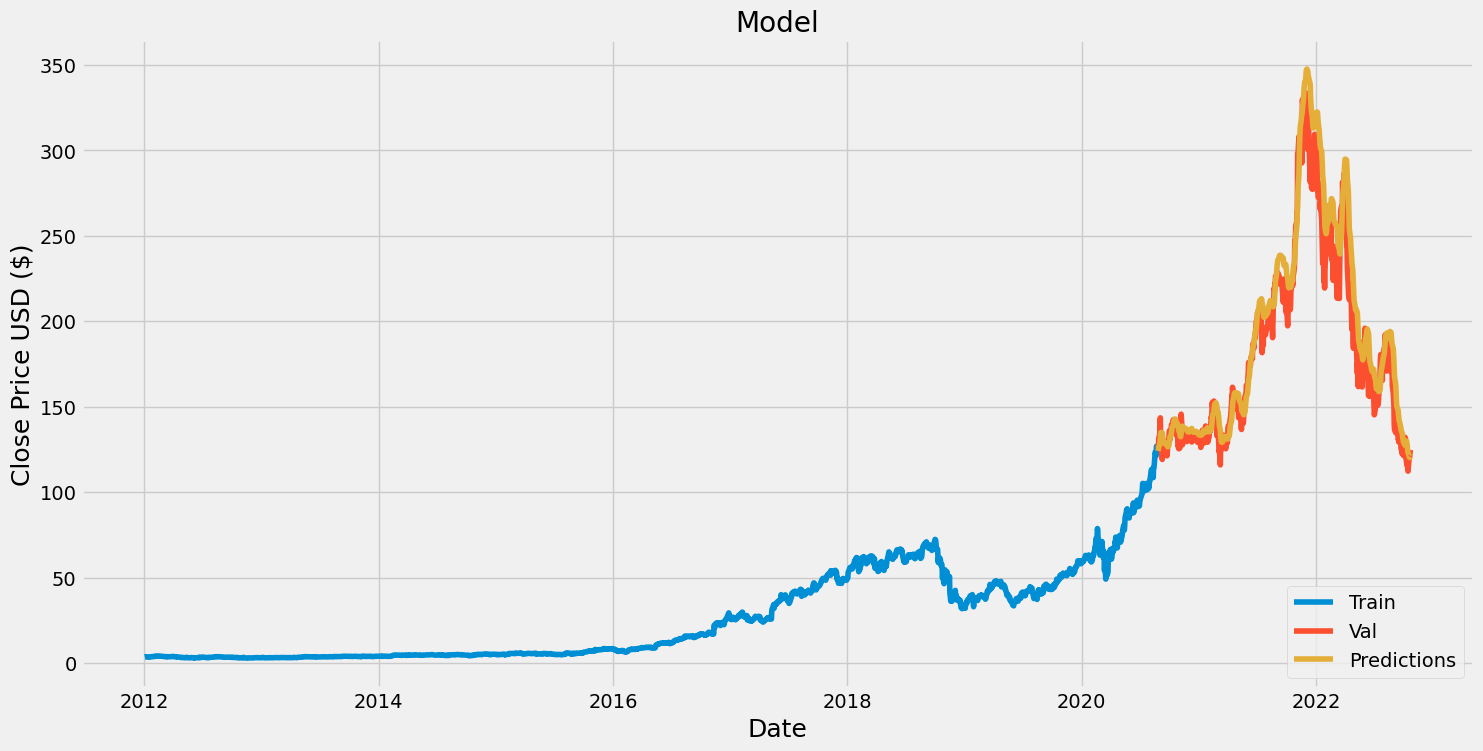

In [16]:
#plot data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

#visualisations
plt.figure(figsize = (16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [17]:
#show the valid and predicted prices
valid

,Close,Predictions
Date,,
2020-08-26,127.730003,124.065094
2020-08-27,126.282501,125.398254
2020-08-28,131.477493,126.315460
2020-08-31,133.744995,127.572937
2020-09-01,138.210007,129.118225
...,...,...
2022-10-17,118.879997,121.409172
2022-10-18,119.669998,120.539688
2022-10-19,120.510002,120.222267


In [77]:
#get the quote
nvda_quote = web.DataReader('NVDA', data_source = 'yahoo', start='2012-01-01', end = '2022-12-22')

new_df = nvda_quote.filter(['Close'])
last_60_days = new_df[-59:]

predicted_prices = []

#Use each predicted price to predict the next price. Understand that this method is flawed.
#My next attempt will make use of a many to many sequence w/ multiple features
for i in range(0,10): 
    last_60_days_scaled = scaler.transform(last_60_days)
    X_test = []
    X_test.append(last_60_days_scaled)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    pred_price = model.predict(X_test)
    pred_price = scaler.inverse_transform(pred_price)
    print(pred_price)
    predicted_prices = np.append(predicted_prices, pred_price)
    last_60_days = np.append(last_60_days, pred_price).reshape(60,1)
    last_60_days = last_60_days[-59:]

1/1 [==============================] - 0s 12ms/step
[[121.58123]]
1/1 [==============================] - 0s 16ms/step
[[122.17194]]
1/1 [==============================] - 0s 15ms/step
[[122.64615]]
1/1 [==============================] - 0s 16ms/step


C:\Users\Daniel\anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


[[123.06531]]
1/1 [==============================] - 0s 18ms/step
[[123.45967]]
1/1 [==============================] - 0s 16ms/step
[[123.844376]]
1/1 [==============================] - 0s 17ms/step
[[124.227104]]
1/1 [==============================] - 0s 16ms/step
[[124.611855]]
1/1 [==============================] - 0s 17ms/step
[[125.00073]]
1/1 [==============================] - 0s 17ms/step
[[125.395035]]


In [80]:
#export as csv
newer_df = pd.DataFrame(columns=['Index'])

newer_df['Close'] = predicted_prices.tolist()

newer_df.head()
newer_df.to_csv(r'C:\Users\Daniel\Downloads\University\FINTECH\Untitled Folder\Untitled Folder\NVDALSTM.csv', index = False, header=True)


array([189.88999939, 177.92999268, 170.86000061, 180.97000122,
       179.41999817, 187.08999634, 190.32000732, 188.78999329,
       183.3500061 , 187.72999573, 178.49000549, 170.33999634,
       171.80999756, 172.22000122, 179.13000488, 162.6000061 ,
       158.00999451, 154.67999268, 150.94000244, 139.36999512,
       136.47000122, 134.6499939 , 137.13999939, 139.8999939 ,
       143.86999512, 145.05000305, 131.30999756, 131.27999878,
       129.28999329, 131.97999573, 133.82000732, 131.75999451,
       132.61000061, 125.61000061, 125.16000366, 122.27999878,
       124.12999725, 127.36000061, 122.19999695, 121.38999939,
       125.12000275, 131.66999817, 132.08999634, 131.30000305,
       120.76000214, 116.69999695, 115.86000061, 115.        ,
       119.59999847, 112.26999664, 118.87999725, 119.66999817,
       120.51000214, 121.94000244, 124.66000366, 121.58123016,
         1.        ,   1.        ,   1.        ])